Part 2: Now we're going to be making a neural network that will allow us to adjust the model which predicts the next character. In this way, we don't necessarily have to rely on the counts of how often the letter appears next, but we'll be able to tune this weights according to the minimizing the loss

First we'll create the training set for all of the bigrams. The idea is that we want the training set to be the first character of the bigram, while the second element in the training set is the predicted (target) for the next character. But we'll be forming them in terms of integers and not the strings themselves

In [1]:
import torch

In [2]:
words = open('names.txt', 'r').read().split()

In [108]:
N = torch.zeros((27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [15]:
xs, ys = [], []

for w in words[:1]:
    print(w)
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(f'ch1 ch2: {ch1} {ch2}')
        print(f'stoi[ch1], stoi[ch2]: {stoi[ch1]} {stoi[ch2]}')
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        
# then we'll turn these into tensors since we'll use them to build the network with PyTorch
xs = torch.tensor(xs)
ys = torch.tensor(ys)

emma
ch1 ch2: . e
stoi[ch1], stoi[ch2]: 0 5
ch1 ch2: e m
stoi[ch1], stoi[ch2]: 5 13
ch1 ch2: m m
stoi[ch1], stoi[ch2]: 13 13
ch1 ch2: m a
stoi[ch1], stoi[ch2]: 13 1
ch1 ch2: a .
stoi[ch1], stoi[ch2]: 1 0


In [7]:
xs

tensor([ 0,  5, 13, 13,  1])

In [16]:
ys

tensor([ 5, 13, 13,  1,  0])

The logic is that when xs[elem] is 0, then we want the neural network to favor ys[elem] to be 5, and same for xs[elem] = 5, we want 13 to be in the target set

Next what we want to do is to be able to encode our inputs, xs, in a way that we can eventually feed them into the neural network. This is known as one_hot.

One_hot is a way to be able to turn some kind of integer-labeled list, and convert it into a vector where the element of the vector will either be 1 if this matches the element where it occurs, or it will obtain a 0 if it does not occur

In [27]:
import torch
import torch.nn.functional as F

# Example tensor of labels
labels = torch.tensor([0, 2, 1, 3])

# Number of classes (unique values in labels)
# technically we could adjust this to not equal len(labels), but that kind of defeats the purpose of one_hot
# since the element of the vector should correspond as to whether the element appears or not
num_classes = 4

# Perform one-hot encoding
one_hot = F.one_hot(labels, num_classes=num_classes)

print(one_hot)

tensor([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])


Now we'll do it for our tensor

In [91]:
import torch
import torch.nn.functional as F

In [36]:
# one_hot doesn't support data type specification, so we have to manually make all of the elements
# set to be float32 
# float32 can be fed into neural nets so this is what we want
xenc = F.one_hot(xs, num_classes=27).float()
print(xenc)
print(xenc.dtype)
print(xenc.shape)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.float32
torch.Size([5, 27])


We can visualize this to make it more easy to see

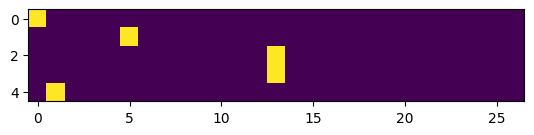

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(xenc)

Now we want to begin constructing our first neuron in order to compute w*x + b, where w*x will be the dot product between our weight vector, which we need to define, and our encoded inputs

In [39]:
W = torch.randn((27, 1))
print(W)
print(W.shape)

tensor([[ 1.1874],
        [ 0.9033],
        [ 1.2363],
        [ 1.5785],
        [ 1.6088],
        [ 1.0526],
        [-0.9510],
        [-1.2195],
        [ 0.3269],
        [-0.4024],
        [ 0.1233],
        [ 1.2649],
        [ 1.2503],
        [-0.6534],
        [ 1.3412],
        [ 0.1028],
        [ 0.0777],
        [ 0.8357],
        [-0.7215],
        [ 0.8080],
        [ 1.5695],
        [-0.5117],
        [ 0.5022],
        [-0.7028],
        [ 0.4897],
        [ 0.3373],
        [ 1.8369]])
torch.Size([27, 1])


The dimensions should be able to match tensor multiplication. xenc.shape is (5, 27) while W.shape is (27, 1), so the output should be a (5, 1) tensor and we'll print it afterwords

Now torch.dot only works with vector multiplication, and it looks like matmul is the best way to do handle general cases

In [41]:
torch.matmul(xenc, W)

tensor([[ 1.1874],
        [ 1.0526],
        [-0.6534],
        [-0.6534],
        [ 0.9033]])

In [42]:
xenc @ W

tensor([[ 1.1874],
        [ 1.0526],
        [-0.6534],
        [-0.6534],
        [ 0.9033]])

Now instead of there being one neuron, we have 27 neurons:

In [61]:
W = torch.randn((27, 27))
res = xenc @ W
print(res)
print(res.shape)

tensor([[ 1.8017, -0.9672, -0.6480, -2.2202,  0.3711,  0.5876,  1.0277, -0.3077,
          2.3207, -0.0508,  1.9148, -0.0178, -0.5968, -0.3641,  0.3521, -0.5240,
          0.2767, -0.5051,  0.6585,  0.9934,  1.6597,  0.4966, -1.1776,  1.5594,
          1.6234, -1.7313, -0.6639],
        [-1.6790, -0.5512,  2.1495,  0.5418,  0.5983, -1.8333,  0.5471,  0.8405,
          0.4083, -1.0899,  0.1273,  1.7569,  3.0191, -2.3936,  0.7517, -0.8810,
          0.8537,  2.1123, -0.5512,  0.4274,  0.7506,  0.6206,  0.4706, -0.5531,
          0.2663,  0.7085,  0.5804],
        [-0.5206,  1.2206, -1.1267,  1.0697, -1.4510,  1.2616, -0.8071, -0.7825,
         -0.7483, -0.0658,  1.5168, -0.1249, -0.3672, -0.4147,  0.2421,  0.8449,
         -0.8644, -0.2355,  0.1899,  0.5728, -0.4563, -1.4228,  1.8715, -0.6236,
          0.4035, -1.6648,  1.1406],
        [-0.5206,  1.2206, -1.1267,  1.0697, -1.4510,  1.2616, -0.8071, -0.7825,
         -0.7483, -0.0658,  1.5168, -0.1249, -0.3672, -0.4147,  0.2421,  0.8449

Now what's happened is that the five original inputs have been multiplied by our weights 27 times, instead of just once, which gives us a much more complicated result

Let's look at what's happening under the hood step by step

In [53]:
(xenc @ W)[3, 13]

tensor(0.3307)

In [54]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
W[:, 13]

tensor([-0.8283,  0.5999,  1.1059,  0.6448, -0.0031,  0.9335,  0.3229,  0.9191,
        -1.8441,  1.0545, -1.3281, -1.9802, -0.9250,  0.3307,  1.0988, -0.6189,
        -1.2421, -1.1420, -1.3161,  0.7108,  1.0059, -0.2576, -0.4908,  0.7756,
         1.2626, -1.3687, -1.4941])

In [59]:
(xenc[3] * W[:, 13]).sum()

tensor(0.3307)

To recap, we are feeding 5 inputs into 27 neurons---this is technically the first layer of our network

Now what we want to do is to be able to interpret our neurons output in a way that makes sense in the context of neural networks. 

One way to do this is to look at the exponential of each element in the output of the matrix multiplcation, which allows all negative numbers to become small positive numbers, while all positive numbers become larger positive values

This turns the output of the neuron into something that looks like a count, where the larger the positive value of the output from this layer of neurons, this represents how more much more likely that index will influence the next layer in the network

In [63]:
(xenc @ W).exp()

tensor([[ 6.0599,  0.3801,  0.5231,  0.1086,  1.4493,  1.7996,  2.7946,  0.7351,
         10.1830,  0.9505,  6.7853,  0.9824,  0.5506,  0.6948,  1.4220,  0.5922,
          1.3187,  0.6034,  1.9319,  2.7004,  5.2578,  1.6431,  0.3080,  4.7559,
          5.0704,  0.1771,  0.5148],
        [ 0.1866,  0.5762,  8.5805,  1.7191,  1.8190,  0.1599,  1.7283,  2.3175,
          1.5042,  0.3363,  1.1358,  5.7942, 20.4721,  0.0913,  2.1205,  0.4144,
          2.3483,  8.2674,  0.5763,  1.5332,  2.1183,  1.8600,  1.6010,  0.5751,
          1.3051,  2.0308,  1.7868],
        [ 0.5942,  3.3893,  0.3241,  2.9144,  0.2343,  3.5311,  0.4461,  0.4573,
          0.4732,  0.9363,  4.5576,  0.8826,  0.6927,  0.6606,  1.2740,  2.3278,
          0.4213,  0.7901,  1.2091,  1.7732,  0.6336,  0.2410,  6.4982,  0.5360,
          1.4971,  0.1892,  3.1288],
        [ 0.5942,  3.3893,  0.3241,  2.9144,  0.2343,  3.5311,  0.4461,  0.4573,
          0.4732,  0.9363,  4.5576,  0.8826,  0.6927,  0.6606,  1.2740,  2.3278

So what we're going to do is interpret the output of xenc @ W as the logits, represnting the log-counts of how often those corresponding indices are likely to show up in subsequent layers, and then the exponential of that is the counts

In [64]:
logits = xenc @ W
counts = logits.exp()
counts

tensor([[ 6.0599,  0.3801,  0.5231,  0.1086,  1.4493,  1.7996,  2.7946,  0.7351,
         10.1830,  0.9505,  6.7853,  0.9824,  0.5506,  0.6948,  1.4220,  0.5922,
          1.3187,  0.6034,  1.9319,  2.7004,  5.2578,  1.6431,  0.3080,  4.7559,
          5.0704,  0.1771,  0.5148],
        [ 0.1866,  0.5762,  8.5805,  1.7191,  1.8190,  0.1599,  1.7283,  2.3175,
          1.5042,  0.3363,  1.1358,  5.7942, 20.4721,  0.0913,  2.1205,  0.4144,
          2.3483,  8.2674,  0.5763,  1.5332,  2.1183,  1.8600,  1.6010,  0.5751,
          1.3051,  2.0308,  1.7868],
        [ 0.5942,  3.3893,  0.3241,  2.9144,  0.2343,  3.5311,  0.4461,  0.4573,
          0.4732,  0.9363,  4.5576,  0.8826,  0.6927,  0.6606,  1.2740,  2.3278,
          0.4213,  0.7901,  1.2091,  1.7732,  0.6336,  0.2410,  6.4982,  0.5360,
          1.4971,  0.1892,  3.1288],
        [ 0.5942,  3.3893,  0.3241,  2.9144,  0.2343,  3.5311,  0.4461,  0.4573,
          0.4732,  0.9363,  4.5576,  0.8826,  0.6927,  0.6606,  1.2740,  2.3278

I think what's interesting is that this is all just an interpretation, because xenc wasn't obtained from using logarithms, but technically it is since log(1) = 0 while log(x) = 1 , and so we're just intepretting the matrix multiplication as forming the logits, while we take the exponential in order to reframe our perspective on what these probabilities really mean

We want to take the sum of 1, since we want to take the element wise division across every element that is part of a column within every row

Need to ensure that we always use keepdims=True in order to maintain the dimensionality of the probabilities

In [66]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.1005, 0.0063, 0.0087, 0.0018, 0.0240, 0.0298, 0.0464, 0.0122, 0.1689,
         0.0158, 0.1125, 0.0163, 0.0091, 0.0115, 0.0236, 0.0098, 0.0219, 0.0100,
         0.0320, 0.0448, 0.0872, 0.0273, 0.0051, 0.0789, 0.0841, 0.0029, 0.0085],
        [0.0026, 0.0079, 0.1176, 0.0236, 0.0249, 0.0022, 0.0237, 0.0318, 0.0206,
         0.0046, 0.0156, 0.0794, 0.2806, 0.0013, 0.0291, 0.0057, 0.0322, 0.1133,
         0.0079, 0.0210, 0.0290, 0.0255, 0.0219, 0.0079, 0.0179, 0.0278, 0.0245],
        [0.0146, 0.0835, 0.0080, 0.0718, 0.0058, 0.0869, 0.0110, 0.0113, 0.0117,
         0.0231, 0.1122, 0.0217, 0.0171, 0.0163, 0.0314, 0.0573, 0.0104, 0.0195,
         0.0298, 0.0437, 0.0156, 0.0059, 0.1600, 0.0132, 0.0369, 0.0047, 0.0770],
        [0.0146, 0.0835, 0.0080, 0.0718, 0.0058, 0.0869, 0.0110, 0.0113, 0.0117,
         0.0231, 0.1122, 0.0217, 0.0171, 0.0163, 0.0314, 0.0573, 0.0104, 0.0195,
         0.0298, 0.0437, 0.0156, 0.0059, 0.1600, 0.0132, 0.0369, 0.0047, 0.0770],
        [0.0286, 0.0578,

In [72]:
probs.shape

torch.Size([5, 27])

In [73]:
probs[0]

tensor([0.1005, 0.0063, 0.0087, 0.0018, 0.0240, 0.0298, 0.0464, 0.0122, 0.1689,
        0.0158, 0.1125, 0.0163, 0.0091, 0.0115, 0.0236, 0.0098, 0.0219, 0.0100,
        0.0320, 0.0448, 0.0872, 0.0273, 0.0051, 0.0789, 0.0841, 0.0029, 0.0085])

The way to interpret the above---at least what I'm getting---is that this row of probabilities correspond to the probability of that character corresponding to that index will appear next, after having been fed that input

In [69]:
# verify that the columns are normalized
probs[0].sum()

tensor(1.)

In [74]:
probs[0].shape # and we see that the row just consists of 27 numbers

torch.Size([27])

# Now we're just going to recap exactly what happened

In [9]:
import torch
import torch.nn.functional as F

In [36]:
N = torch.zeros((27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [37]:
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        
# then we'll turn these into tensors since we'll use them to build the network with PyTorch
xs = torch.tensor(xs)
ys = torch.tensor(ys)

Our data set will just be the first word in the names dataset for now

In [38]:
xs # these are our inputs

tensor([ 0,  5, 13, 13,  1])

In [39]:
ys # these are our target labels, where this is optimally what we want the neural net to optimize its weights for
    # in order to be correctly predict the next best word that should follow the one that was given

tensor([ 5, 13, 13,  1,  0])

In [40]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # remember to set requires_grad
W.shape

torch.Size([27, 27])

Now we're going to make our encoding, make our logits, and obtain the probabilities that are associated with the correct letter that should follow from the input

Make sure to always make your encoding floats, since one_hot doesn't support this from the method itself

In [41]:
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [42]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

The above is called the softmax! And what we did is do a forward pass in the network. From micrograd, we know how to do backgropogation, since the local probabilities were obtained using multiplication, so this will be an easy chain rule to set

We can automate each part of what happens in the neural network as follows

In [43]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print('-------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indices {x} {y})')
    print(f'input to the neural network: {x}')
    print(f'output probabilities from the layer of 27 neurons: {probs[i]}')
    print(f'the target label that we are aiming to predict next: {y}')
    prob = probs[i][y]
    print(f'according to the network, the probability it will show up next is: {prob:.4f}')
    logprob = torch.log(prob)
    nll = -logprob
    print(f'this translates into a log likelihood of: {logprob}')
    print(f'the negative log likelihood is then {nll}')
    nlls[i] = nll
    print(f'what nlls looks like: {nlls}')
    
print('----------')
print(f'average nll: {nlls.mean().item()}')

-------
bigram example 1: .e (indices 0 5)
input to the neural network: 0
output probabilities from the layer of 27 neurons: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
       grad_fn=<SelectBackward0>)
the target label that we are aiming to predict next: 5
according to the network, the probability it will show up next is: 0.0123
this translates into a log likelihood of: -4.399273872375488
the negative log likelihood is then 4.399273872375488
what nlls looks like: tensor([4.3993, 0.0000, 0.0000, 0.0000, 0.0000], grad_fn=<CopySlices>)
-------
bigram example 2: em (indices 5 13)
input to the neural network: 5
output probabilities from the layer of 27 neurons: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0

What happened was that the network has super high loss! It's not very good right now. This has to do with that W was pretty crappy with giving up weights that would matrix multiply with our encoded inputs

We used negative likelihood because we are doing classification now, when in micrograd, we did the mean squared error because that was a regression problem. Your loss function is indeed a choice, so it's kind of up to you on exactly how you want to update your weights

Now we're going to be doing back propogation, since we've just done the forward pass above

 Now in order to pick out the correct probabilities that correspond to the next letter that should be correctly predicted: this should correspond to what we'd expect given that we have the target labels

In [44]:
probs[0, 5], probs[1, 13], probs[2, 1], probs[3, 1], probs[4, 0]

(tensor(0.0123, grad_fn=<SelectBackward0>),
 tensor(0.0181, grad_fn=<SelectBackward0>),
 tensor(0.0737, grad_fn=<SelectBackward0>),
 tensor(0.0737, grad_fn=<SelectBackward0>),
 tensor(0.0150, grad_fn=<SelectBackward0>))

We want an easier way to be able to obtain these probabilities in a more efficient way, and we'll do this using torch

In [45]:
#torch.arange(5) # first we get the indices
probs[torch.arange(5), ys] # this is incredible and funny

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150], grad_fn=<IndexBackward0>)

now that we've efficiently obtained the probabilities along with their corresponding indices, we'll now obtain the loss function for classification---the negative log likelihood

In [46]:
loss = -probs[torch.arange(len(ys)), ys].log().mean()
loss # this matches what we got previously, but in a completely vectorized form!

tensor(3.7693, grad_fn=<NegBackward0>)

Now all we need is to construct the backward pass and we're good to go!

In [47]:
W.grad = None

The beauty of PyTorch is that the (digraphs?) that we used to do all of the things that we developed for micrograd, are built in-situ. This means that all of the mathematical dependencies that led to the loss function are built into a graphical structure, and when you call loss.backward(), PyTorch will perform backpropogation all the way back to the weights!

In [48]:
loss.backward()

Let's check out what happened to W.grad under the hood

In [69]:
W.grad
#torch.where(W.grad[0] == min(W.grad[0]))
#W.grad[0][5]

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

Only the indices that were associated with the name 'emma' were adjusted in W.grad, which makes sense, since this is the only name that the network was trained on

Remember that positive gradients will increase the loss, so basically what we're essentially aiming to do with our loss function and calculating gradients is that we want the loss function to be minimized, so what needs to happen is that the gradients need to be negative---this makes sense bc it looks like most of the gradient elements that were negative ended up corresponding to the correct indices that would succeed 

In [70]:
# finally we need to update the data based on the gradient information
W.data += -0.1 * W.grad